In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from harmony import harmonize

import sys
sys.path.append("../resources/")
import sct

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
adata = sc.read_h5ad('../data/adult_all.h5ad')
adata

AnnData object with n_obs × n_vars = 1200 × 15264 
    obs: 'PN_type', 'genotype', 'n_counts', 'n_genes', 'stage', 'conc'
    var: 'highly_variable'
    uns: 'PN_type_colors', 'genotype_colors', 'leiden', 'neighbors'
    obsm: 'X_pca', 'X_tsne'

In [4]:
adata.obs['genotype'].value_counts()

GH146-GFP       570
VT033006-GFP    394
kn-GFP          141
Mz19-GFP         95
Name: genotype, dtype: int64

In [5]:
adata.var['highly_variable'].value_counts()

False    14703
True       561
Name: highly_variable, dtype: int64

In [6]:
# get knot+ cells from adult pan-PN cells
adata_kn_1 = adata[(adata.obs['genotype'] == 'GH146-GFP') & (adata.to_df()['kn'] > 4)]
adata_kn_1

View of AnnData object with n_obs × n_vars = 102 × 15264 
    obs: 'PN_type', 'genotype', 'n_counts', 'n_genes', 'stage', 'conc'
    var: 'highly_variable'
    uns: 'PN_type_colors', 'leiden', 'neighbors'
    obsm: 'X_pca', 'X_tsne'

In [7]:
# get adult cells from knot-GAL4
adata_kn_all = sc.read_h5ad('../data/knot_24h_48h_adult.h5ad')
adata_kn_all
adata_kn_2 = adata_kn_all[adata_kn_all.obs['stage'] == 'adult']
adata_kn_2

View of AnnData object with n_obs × n_vars = 141 × 17474 
    obs: 'stage', 'HDBSCAN', 'PN_type', 'genotype'
    uns: 'HDBSCAN_colors', 'PN_type_colors', 'stage_colors'
    obsm: 'X_tsne'

In [8]:
adata_conc = adata_kn_1.concatenate(adata_kn_2, index_unique=None)
adata_conc

AnnData object with n_obs × n_vars = 243 × 15264 
    obs: 'HDBSCAN', 'PN_type', 'batch', 'conc', 'genotype', 'n_counts', 'n_genes', 'stage'
    var: 'highly_variable-0'
    obsm: 'X_tsne'

In [9]:
df_libs = pd.read_csv("../data/libs.csv", sep="\t", header=0, index_col=0) # sample info

# plot combined cell data with kn

In [10]:
adata_conc.var['highly_variable'] = adata_conc.var['highly_variable-0']
sc.pp.pca(adata_conc, svd_solver='arpack', use_highly_variable=True, random_state=1)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)


In [11]:
adata_conc.obsm['X_pca'] = harmonize(adata_conc.obsm['X_pca'], adata_conc.obs, batch_key=['genotype'])

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [12]:
sc.tl.tsne(adata_conc, n_pcs=20, perplexity=10, learning_rate=250, 
           early_exaggeration=4.0, random_state=1)

computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)


In [13]:
adata_conc.uns['genotype_colors'] = ['#b9bbbd', '#1f77b4']

... storing 'HDBSCAN' as categorical
... storing 'PN_type' as categorical
... storing 'genotype' as categorical


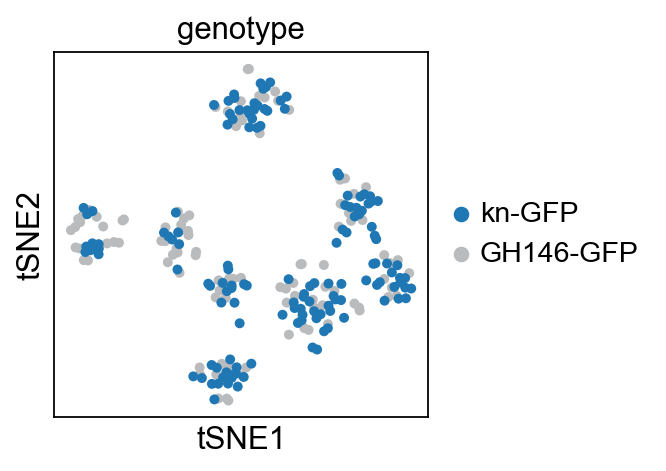

In [14]:
sc.set_figure_params(figsize=(3,3), dpi_save=600)
sc.pl.tsne(adata_conc, color='genotype', size=(80,80), groups=['kn-GFP','GH146-GFP'], save='_adult_kn.pdf')

In [24]:
adata_conc.obs['PN_type_1'] = 'nan'
PN_type_1 = adata_kn_all[(adata_kn_all.obs['genotype'] == 'kn-GFP')].obs['PN_type']
PN_type_1 = PN_type_1.replace('NaN','nan')
PN_type_1 = PN_type_1.astype('category')
PN_type_1 = PN_type_1.replace('vPN_DA1','vPN')
PN_type_1 = PN_type_1.cat.remove_unused_categories()
PN_type_1.value_counts()

D                        81
VA1v                     77
vPN                      68
DM4 or VM5v (CG8861+)    64
DM4 or VM5v (CG8861-)    55
DM6                      51
VM2                      46
nan                      22
Name: PN_type, dtype: int64

In [40]:
adata_conc.obs['PN_type_1'] = PN_type_1
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].replace('DM4 or VM5v (CG8861+)','VM7 or VM5v #1')
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].replace('DM4 or VM5v (CG8861-)','VM7 or VM5v #2')
adata_conc.obs['PN_type_1'][np.in1d(adata_conc.obs['PN_type_1'], ['vPN_DA1'])] = 'vPN'
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].replace('nan','not decoded')
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].astype('category')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [42]:
adata_conc.obs['PN_type_1'].value_counts()

VM7 or VM5v #1    28
VA1v              26
DM6               22
D                 18
vPN               17
VM2               17
VM7 or VM5v #2    13
Name: PN_type_1, dtype: int64

In [46]:
adata_conc.uns['PN_type_colors'] = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b9bbbd']

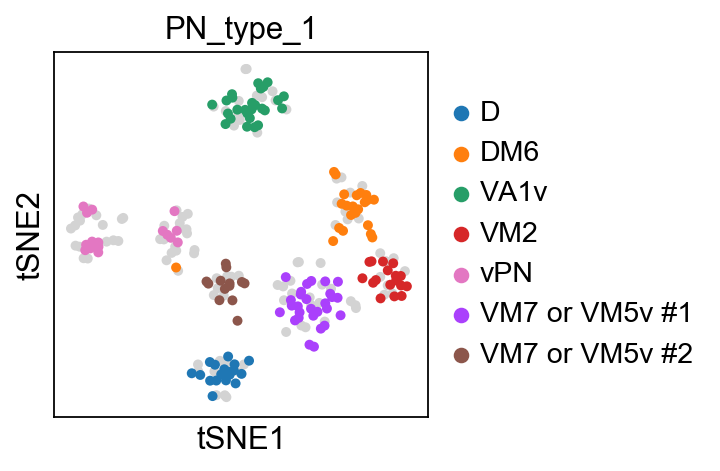

In [47]:
sc.pl.tsne(adata_conc, color='PN_type_1', size=(80,80), 
           groups=['D', 'DM6', 'VA1v', 'VM2', 'vPN', 'VM7 or VM5v #1','VM7 or VM5v #2'],
           save='_PN_type_kn.pdf')

# match with Mz19 data

In [48]:
adata.obs['genotype'].value_counts()

GH146-GFP       570
VT033006-GFP    394
kn-GFP          141
Mz19-GFP         95
Name: genotype, dtype: int64

In [49]:
adata_select = adata[(adata.obs['genotype'] == 'GH146-GFP') | (adata.obs['genotype'] == 'Mz19-GFP')]

In [50]:
adata_select.obs['genotype'].value_counts()

GH146-GFP    570
Mz19-GFP      95
Name: genotype, dtype: int64

In [51]:
sc.pp.pca(adata_select, svd_solver='arpack', use_highly_variable=True, random_state=1)
adata_select.obsm['X_pca'] = harmonize(adata_select.obsm['X_pca'], adata_select.obs, batch_key=['genotype'])
sc.tl.tsne(adata_select, n_pcs=50, perplexity=10, learning_rate=250, 
           early_exaggeration=4.0, random_state=1)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:02)


In [52]:
adata_select.uns['genotype_colors'] = ['#aba6a6','#279e68']

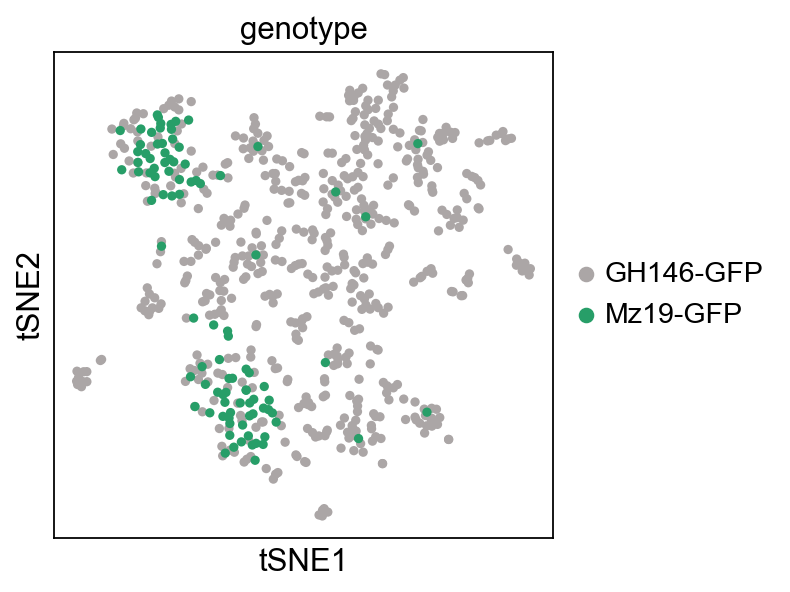

In [53]:
sc.set_figure_params(figsize=(4,4),dpi_save=600)
sc.pl.tsne(adata_select, color='genotype', size=(70,70), save='_genotype_1.pdf')

In [56]:
adata_mz19 = adata[adata.obs['genotype'] == 'Mz19-GFP']
adata_mz19

View of AnnData object with n_obs × n_vars = 95 × 15264 
    obs: 'PN_type', 'genotype', 'n_counts', 'n_genes', 'stage', 'conc'
    var: 'highly_variable'
    uns: 'PN_type_colors', 'leiden', 'neighbors'
    obsm: 'X_pca', 'X_tsne'

In [60]:
adata_select.obs['PN_type_1'] = adata_mz19.obs['PN_type']
adata_select.obs['PN_type_1'] = adata_select.obs['PN_type_1'].replace('nan','not decoded')
adata_select.obs['PN_type_1'] = adata_select.obs['PN_type_1'].astype('category')

In [62]:
adata_select.obs['PN_type_1'].value_counts()

DC3 and VA1d    39
not decoded     38
DA1             18
Name: PN_type_1, dtype: int64

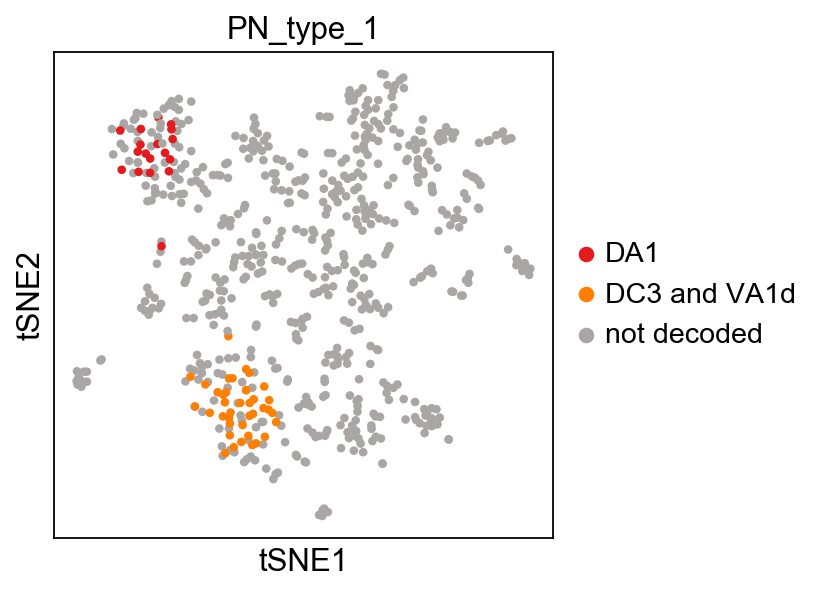

In [64]:
adata_select.uns['PN_type_1_colors'] = ['#e41a1c', '#ff7f00', '#aba6a6']
sc.pl.tsne(adata_select, color='PN_type_1', size=(60,60), save='_PN_type.pdf')